In [191]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az
import seaborn as sns
from numpyro.diagnostics import hpdi
import pandas as pd
import numpy as np
import random

<h1> Generate Data </h1>

$$y_i \sim \beta_i + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma^2)$$
Similarly to Piironen's toy example, We generate $N$ data realizations with $n=400$ observations per realization. Our true parameter vector $\beta^*$ has $p^*=20$ non-zero entries with some value $A \in$ $\{1, 2, ..., 10\}$ and $D=400$ total variables. 

In [173]:
# Parameters
n_realizations = 10
p = 400  # Total number of predictors
p_star = 20 # Total number of non-zero predictors
sigma = 1 # Noise parameter

# Generate data
def get_data(A):
    y_realizations = [] 
    beta_stars = [] 
    for _ in range(n_realizations):
        # Create true beta vector beta_star
        beta_star = np.zeros(p)
        beta_star[range(20)] = A

        # Generate response variable y
        y = beta_star + np.random.randn(p) * sigma

        # Store the generated data
        y_realizations.append(y)
        beta_stars.append(beta_star)

    # Convert lists to numpy arrays 
    y_realizations = np.array(y_realizations) # shape = 2 x 400
    beta_stars = np.array(beta_stars) # shape = 2 x 400
    return y_realizations, beta_stars

all_data = {}
A_values = [4, 6]
for A in A_values:
    all_data[A] = get_data(A) #all_data[A] = (y_realizations, beta_stars) for that particular A

<h2> Define the Model </h2>

Horseshoe prior:
$$ y_i \sim N(\beta_i, \sigma^2) \quad \text{for } i = 1,2,\ldots,n$$ 
$$ \beta_i \sim N(0, \tau^2 \lambda_i^2) $$
$$ \lambda_i \sim C^+(0, 1)$$




We will compare two different hyperpriors for $\tau$: 

$\tau \sim C^+(0, 1)$ and $\tau = \tau_0 = \frac{p^*}{D-p^*}\sigma$.

In [174]:
def horseshoe_linear_model(tau, y=None, sigma=1):
    '''
    Parameters:
       array y: dependent variable
       int sigma: stdev of y
    '''
    n_predictors = y.shape[0]
    if tau == "Half-Cauchy":
       tau = numpyro.sample('tau', dist.HalfCauchy(1))
    elif tau =="Tau_0":
       tau = (20 * sigma) / (400 - 20)
    else:
       raise ValueError
    lambdas = numpyro.sample("lambdas", dist.HalfCauchy(jnp.ones(n_predictors)))
    # slightly different parametrization for efficiency
    unscaled_betas = numpyro.sample("unscaled_betas", dist.Normal(0, 1).expand([n_predictors]))
    scaled_betas = numpyro.deterministic("betas", tau*lambdas*unscaled_betas)

    numpyro.sample('y', dist.Normal(scaled_betas, sigma), obs=y)

<h1> Run and Evaluate MCMC </h1>

In [175]:
def run_mcmc(tau, y):
    horseshoe_mcmc = MCMC(
        NUTS(horseshoe_linear_model),
        num_warmup=500,
        num_samples=1000,
        num_chains = 4
    )
    horseshoe_mcmc.run(random.PRNGKey(1), tau=tau, y=y)
    return horseshoe_mcmc

all_samples = {}
all_mcmc_runs = []
for A, (y_realizations, beta_stars) in all_data.items():
    all_samples[A] = {}
    samples = []
    for y in y_realizations:
        mcmc_1 = run_mcmc(tau="Half-Cauchy", y=y)
        samples.append(mcmc_1.get_samples())
        all_mcmc_runs.append(mcmc_1)
    all_samples[A]['Half-Cauchy'] = samples

for A, (y_realizations, beta_stars) in all_data.items():
    samples = []
    for y in y_realizations:
        mcmc_2 = run_mcmc(tau="Tau_0", y=y)
        samples.append(mcmc_2.get_samples())
        all_mcmc_runs.append(mcmc_2)
    all_samples[A]['Tau_0'] = samples

# all_samples is a dictionary 
# all_samples[A] is a list of length 'n_realizations'. each item in the list is a dictionary.

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_21678/907434811.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  horseshoe_mcmc = MCMC(
sample: 100%|██████████| 1500/1500 [00:02<00:00, 748.72it/s, 127 steps of size 4.72e-02. acc. prob=0.87]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_21678/907434811.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  horseshoe_mcmc = MCMC(
sam

The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [176]:
for mcmc in all_mcmc_runs:
    print(az.ess(mcmc))
    print(az.rhat(mcmc))

<xarray.Dataset> Size: 19kB
Dimensions:               (betas_dim_0: 400, lambdas_dim_0: 400,
                           unscaled_betas_dim_0: 400)
Coordinates:
  * betas_dim_0           (betas_dim_0) int64 3kB 0 1 2 3 4 ... 396 397 398 399
  * lambdas_dim_0         (lambdas_dim_0) int64 3kB 0 1 2 3 ... 396 397 398 399
  * unscaled_betas_dim_0  (unscaled_betas_dim_0) int64 3kB 0 1 2 ... 397 398 399
Data variables:
    betas                 (betas_dim_0) float64 3kB 990.0 701.4 ... 3.721e+03
    lambdas               (lambdas_dim_0) float64 3kB 648.4 787.1 ... 1.631e+03
    tau                   float64 8B 1.052e+03
    unscaled_betas        (unscaled_betas_dim_0) float64 3kB 704.2 ... 3.62e+03
<xarray.Dataset> Size: 19kB
Dimensions:               (betas_dim_0: 400, lambdas_dim_0: 400,
                           unscaled_betas_dim_0: 400)
Coordinates:
  * betas_dim_0           (betas_dim_0) int64 3kB 0 1 2 3 4 ... 396 397 398 399
  * lambdas_dim_0         (lambdas_dim_0) int64 3kB 0 1 2 

<h1> Results </h1>

[Text(0.5, 0, 'Entry $i$')]

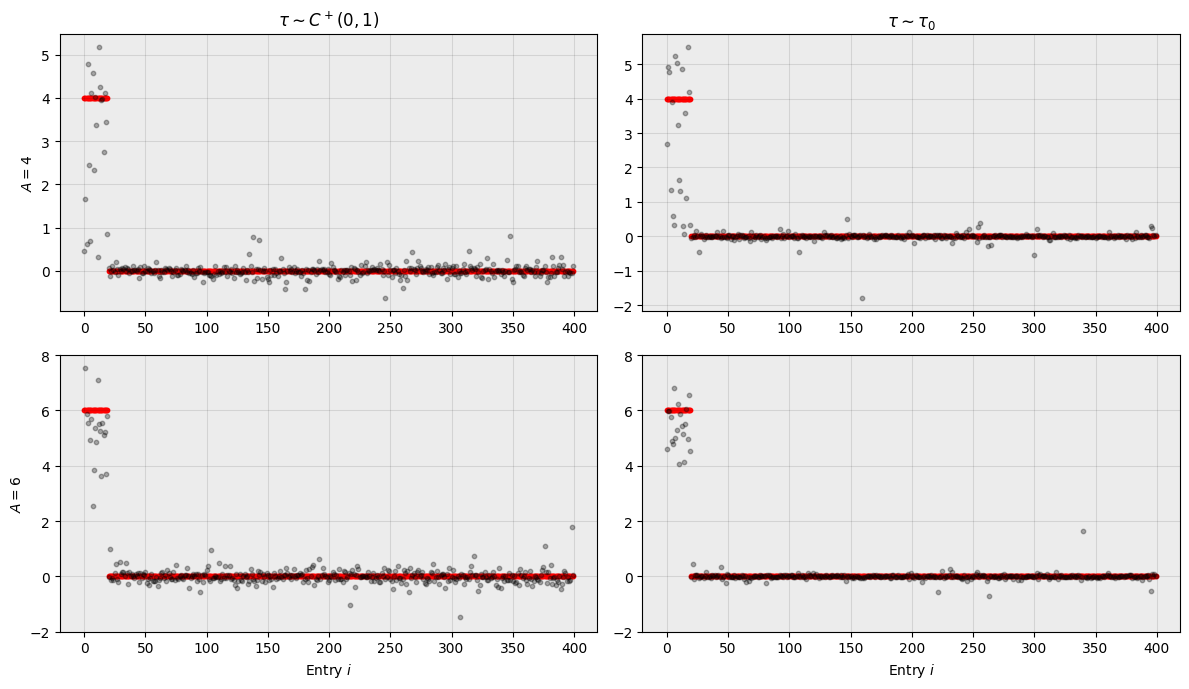

In [194]:
def plot_posterior_betas(A, beta_stars, posterior_samples, ax):
    i = random.randrange(0, len(beta_stars))
    estimated_betas = posterior_samples[i]['betas'].mean(axis=0) # get the average value of beta_i for all 4000 samples (4 chains x 1000 samples/chain)
    ax.scatter(range(len(beta_stars[i])), beta_stars[i], color='red', s=10, label='True Betas' if i == 0 else "") # plot actual betas
    ax.scatter(range(len(estimated_betas)), estimated_betas, color='black', s=10, alpha=0.3, label='Estimated Betas' if i == 0 else "") # plot estimated betas
    

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7), layout="tight")
for ax in [ax1, ax2, ax3, ax4]: 
    #ax.label_outer() # hide x-labels and tick labels for some plots
    ax.set_facecolor("#ECECEC") # set graph background color to grey
    ax.grid(visible=True, color="black", alpha=0.1) # add grid lines

# resetting y-axis range so that the bottom two graphs line up
ax4.set_ylim([-2, 8]) 
ax3.set_ylim([-2, 8])

# call plotting function on every combination of ["Half-Cauchy", "Tau_0"] x [4, 6]
d = {4: {"Half-Cauchy": ax1, "Tau_0": ax2}, 6: {"Half-Cauchy": ax3, "Tau_0": ax4}}
for A in A_values:
    for tau in ["Half-Cauchy", "Tau_0"]:
        y_realizations, beta_stars = all_data[A]
        plot_posterior_betas(A, beta_stars, all_samples[A][tau], d[A][tau])

# add labels to graph
ax1.set_title(r'$\tau \sim C^+(0, 1)$')
ax2.set_title(r'$\tau \sim \tau_0$')
ax1.set(ylabel=r'$A=4$')
ax3.set(ylabel=r'$A=6$', xlabel=r'Entry $i$')
ax4.set(xlabel=r'Entry $i$')


Comparing the two plots above, we can see that $A=4$ overshrinks some of the nonzero components.